In [182]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [183]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
import lightgbm as LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc


In [184]:
train = pd.read_csv('WFS_Training.csv', na_values = 'null')#,nrows=50000)
public_test = pd.read_csv('WFS_TestFeatures.csv', na_values = 'null')#,nrows=50000)
candidates = pd.read_csv('WFS_ML_Challenge1_candidate_features.csv', na_values = 'null')
shifts = pd.read_csv('WFS_ML_Challenge1_shift_features.csv', na_values = 'null')

In [185]:
#filtering shift_code_group fregasega
common = train.merge(shifts,on=['shift_code','shift_code'])
train = train[(train.shift_code.isin(common.shift_code))]

common = public_test.merge(shifts,on=['shift_code','shift_code'])
public_test = public_test[(public_test.shift_code.isin(common.shift_code))]

In [186]:
#only with candidate features
score_cols = [
    'commute_distance',
    #'shift_duration'
]
cat_cols = [
           'app_esl_status',
            'cand_education',
            'cand_assess_overall_score',
            #'shift_code_group',
            #'shift_days_of_week',
            #'shift_emp_class',
            #'shift_startday',
            #'shift_type',
            #'shift_schedule_type',
            #'shift_start_time_group'
           ]
feat_cols = [
          # 'appointment_nbr',
          # 'application_per_candidate',
            #'day_to_first_app',
           # 'appointment_for_app',
]


In [187]:
train['create_year'] = pd.DatetimeIndex(train.app_created_date).year
train['create_month'] = pd.DatetimeIndex(train.app_created_date).month
train['create_day'] = pd.DatetimeIndex(train.app_created_date).day

train['app_year'] = pd.DatetimeIndex(train.appt_1_date).year
train['app_month'] = pd.DatetimeIndex(train.appt_1_date).month
train['app_day'] = pd.DatetimeIndex(train.appt_1_date).day
train['app_quarter'] = pd.DatetimeIndex(train.appt_1_date).quarter
train['app_weekday'] = pd.DatetimeIndex(train.appt_1_date).weekday
train['app_weekend'] = (train['app_weekday'] // 5 == 1).astype(float)


public_test['create_year'] = pd.DatetimeIndex(public_test.app_created_date).year
public_test['create_month'] = pd.DatetimeIndex(public_test.app_created_date).month
public_test['create_day'] = pd.DatetimeIndex(public_test.app_created_date).day

public_test['app_year'] = pd.DatetimeIndex(public_test.appt_1_date).year
public_test['app_month'] = pd.DatetimeIndex(public_test.appt_1_date).month
public_test['app_day'] = pd.DatetimeIndex(public_test.appt_1_date).day
public_test['app_quarter'] = pd.DatetimeIndex(public_test.appt_1_date).quarter
public_test['app_weekday'] = pd.DatetimeIndex(public_test.appt_1_date).weekday
public_test['app_weekend'] = (public_test['app_weekday'] // 5 == 1).astype(float)


candidates['create_year'] = pd.DatetimeIndex(candidates.app_created_date).year
candidates['create_month'] = pd.DatetimeIndex(candidates.app_created_date).month
candidates['create_day'] = pd.DatetimeIndex(candidates.app_created_date).day


date_cols = [
#'create_year', 
#'create_month', 
#'create_day',
#'app_year',
#'app_month',
#'app_day',
#'app_quarter',
#'app_weekday',
#'app_weekend'
]

#cat_cols = cat_cols + date_cols

In [188]:
#application_per_candidate to rewrite
'''
train['appointment_for_app'] = train.groupby('app_id')['cand_id'].transform('count')
public_test['appointment_for_app'] = public_test.groupby('app_id')['cand_id'].transform('count')
train['appointment_nbr'] = train.sort_values(['ID'], ascending=[True]) \
             .groupby(['cand_id']).cumcount() + 1
public_test['appointment_nbr'] = public_test.sort_values(['ID'], ascending=[True]) \
             .groupby(['cand_id']).cumcount() + 1

train['day_to_first_app'] = (pd.DatetimeIndex(train.appt_1_date) - pd.DatetimeIndex(train.app_created_date)).days
public_test['day_to_first_app'] = (pd.DatetimeIndex(public_test.appt_1_date) - pd.DatetimeIndex(public_test.app_created_date)).days
'''

"\ntrain['appointment_for_app'] = train.groupby('app_id')['cand_id'].transform('count')\npublic_test['appointment_for_app'] = public_test.groupby('app_id')['cand_id'].transform('count')\ntrain['appointment_nbr'] = train.sort_values(['ID'], ascending=[True])              .groupby(['cand_id']).cumcount() + 1\npublic_test['appointment_nbr'] = public_test.sort_values(['ID'], ascending=[True])              .groupby(['cand_id']).cumcount() + 1\n\ntrain['day_to_first_app'] = (pd.DatetimeIndex(train.appt_1_date) - pd.DatetimeIndex(train.app_created_date)).days\npublic_test['day_to_first_app'] = (pd.DatetimeIndex(public_test.appt_1_date) - pd.DatetimeIndex(public_test.app_created_date)).days\n"

In [189]:
# Mean Scores###
train = train.fillna(train[score_cols].mean())
public_test = public_test.fillna(public_test[score_cols].mean())
candidates = candidates.fillna(public_test[score_cols].mean())

### not specified for categorical ###
ns_value = '1500'
train[cat_cols] = train[cat_cols].fillna(ns_value)
public_test[cat_cols] = public_test[cat_cols].fillna(ns_value)
candidates[cat_cols] = candidates[cat_cols].fillna(ns_value)

In [190]:
#train[date_cols] = train[date_cols].astype(int)
#public_test[date_cols] = public_test[date_cols].astype(int)

In [191]:
'''
train['shift_start_time_group'] = train['shift_start_time_group'].astype(int)
public_test['shift_start_time_group'] = public_test['shift_start_time_group'].astype(int)
'''

"\ntrain['shift_start_time_group'] = train['shift_start_time_group'].astype(int)\npublic_test['shift_start_time_group'] = public_test['shift_start_time_group'].astype(int)\n"

In [192]:
#labeling also the target
for c in cat_cols:
    le = LabelEncoder()
    unique_elements = list(set(train[c].values.tolist() 
                               + public_test[c].values.tolist()
                               + candidates[c].values.tolist()))
    le.fit(unique_elements)
    train[c] = le.transform(train[c])
    public_test[c] = le.transform(public_test[c])
    candidates[c] = le.transform(candidates[c])

In [193]:
dataset = pd.concat([train, public_test], axis=0)

In [194]:
dataset = dataset.reset_index(drop=True)

In [195]:
from collections import Counter
Counter(dataset.shift_code)

Counter({'AAAA': 69975,
         'ACCPT': 1403,
         'DA5-0430': 44,
         'DA5-0630': 43,
         'DA5-0700': 1584,
         'DA5-0715': 104,
         'DA5-0730': 2184,
         'DA5-0800': 127,
         'DA5-0830': 187,
         'DA5-0900': 224,
         'DA5-0930': 486,
         'DA5T0700': 334,
         'DA5T0730': 328,
         'DA6-0615': 73,
         'DA6-0700': 1080,
         'DA6-0730': 1048,
         'DA7-0615': 101,
         'DA7-0700': 1665,
         'DA7-0715': 237,
         'DA7-0730': 1377,
         'DA7T0700': 406,
         'DA7T0730': 396,
         'DB1-0630': 38,
         'DB1-0700': 1581,
         'DB1-0730': 1912,
         'DB1-0830': 122,
         'DB1-0930': 505,
         'DB1T0700': 454,
         'DB1X0630': 5,
         'DB2-0615': 119,
         'DB2-0700': 1252,
         'DB2-0730': 1107,
         'DB2-0800': 121,
         'DB2-0900': 159,
         'DB2-0930': 33,
         'DB3-0700': 1355,
         'DB3-0715': 170,
         'DB3-0730': 1666,
         'D

In [196]:
from collections import Counter
for job, cnt in Counter(dataset.shift_code).items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if int(cnt) == 1:
        print('class to be removed is {}',format(job))
        dataset = dataset[dataset.shift_code != job]

('class to be removed is {}', 'PT148')


In [197]:
target_col = 'shift_code'
tgt = LabelEncoder()
unique_elements = list(set(dataset[target_col].values.tolist()))
tgt.fit(unique_elements)
dataset[target_col] = tgt.transform(dataset[target_col])

In [198]:
#labeling also the target
'''
target_col = 'shift_code'
tgt = LabelEncoder()
unique_elements = list(set(train[target_col].values.tolist() + public_test[target_col].values.tolist()))
tgt.fit(unique_elements)
train[target_col] = tgt.transform(train[target_col])
public_test[target_col] = tgt.transform(public_test[target_col])
'''

"\ntarget_col = 'shift_code'\ntgt = LabelEncoder()\nunique_elements = list(set(train[target_col].values.tolist() + public_test[target_col].values.tolist()))\ntgt.fit(unique_elements)\ntrain[target_col] = tgt.transform(train[target_col])\npublic_test[target_col] = tgt.transform(public_test[target_col])\n"

In [199]:
classes = list(unique_elements)
n_class = len(set(classes))
n_class

363

In [200]:
X= dataset.loc[:, dataset.columns != 'shift_code']
y= dataset.shift_code

In [201]:
X = X[feat_cols + score_cols + cat_cols + date_cols]

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=10, 
                                                test_size=0.25,
                                               stratify=y)                                               

In [219]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective':'multiclass',
        #'metric':'accuracy',
         'num_class': n_class,
         'max_depth': 7, 
     #   'num_leaves': 70,
     #   'max_bin': 100,
    #     'lambda_l1': 0.1,
    #     'lambda_l2': 0.1,
    #   'min_gain_to_split': 0.1,
    #    'feature_fraction': 0.3,
    #    'bagging_fraction': 0.3,
    #    'scale_pos_weight' : 0.7,
        'class_weight': 'balanced',
    #    'learning_rate': 0.01,
    #     'max_depth': 7,
     #   'eta': 0.2,
    #    'gamma':4,
    #    'min_child_weight':6,
    #   'min_child_sample':6,
    #  'num_leaves': 8,
    #'scale_pos_weight':0.33
        }

In [220]:

lgtrain = LGBMClassifier.Dataset(X_train, label=y_train)
lgval = LGBMClassifier.Dataset(X_test, label=y_test)


early_stopping_rounds = 30

search_time_start = time.time()
gbm = LGBMClassifier.train(params,
                    lgtrain,
                    num_boost_round=1000,
                    verbose_eval=100,
                    valid_sets=[lgtrain, lgval],
                    categorical_feature = cat_cols+date_cols,
                    early_stopping_rounds=early_stopping_rounds
                          )
print("train time:", time.time() - search_time_start)
search_time_start = time.time()
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print("prediction time:", time.time() - search_time_start)
print('accuracy %s' % accuracy_score(np.argmax(y_pred,1), y_test))

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app_esl_status', 'cand_assess_overall_score', 'cand_education']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app_esl_status', 'cand_assess_overall_score', 'cand_education']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's multi_logloss: 4.21453	valid_1's multi_logloss: 4.26512
('train time:', 151.55106592178345)
('prediction time:', 0.8126609325408936)
accuracy 0.305280205015038


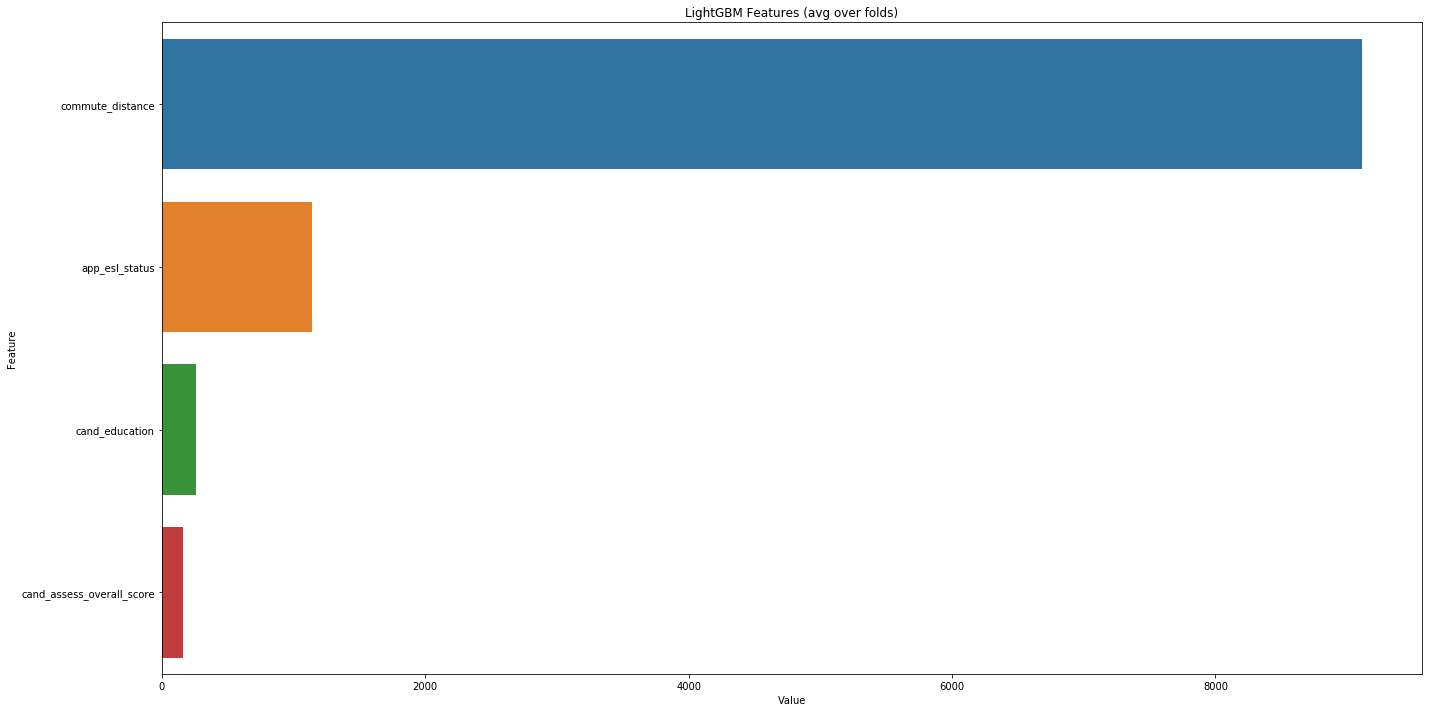

<Figure size 432x288 with 0 Axes>

In [221]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [213]:
predictions = candidates.copy()
predictions = predictions[['cand_id']+feat_cols + score_cols + cat_cols + date_cols]
predict =  gbm.predict(predictions.loc[:, predictions.columns != 'cand_id'].values, num_iteration=gbm.best_iteration)

top_n_predict = [predict[i].argsort()[-5:][::-1] for i in range(predict.shape[0])]


predictions['rank1_shiftcode'] = [top_n_predict[i][0] for i in range(len(top_n_predict))]
predictions['rank2_shiftcode'] = [top_n_predict[i][1] for i in range(len(top_n_predict))]
predictions['rank3_shiftcode'] = [top_n_predict[i][2] for i in range(len(top_n_predict))]
predictions['rank4_shiftcode'] = [top_n_predict[i][3] for i in range(len(top_n_predict))]
predictions['rank5_shiftcode'] = [top_n_predict[i][4] for i in range(len(top_n_predict))]

rank_cols = ['rank1_shiftcode', 'rank2_shiftcode', 'rank3_shiftcode'
            , 'rank4_shiftcode', 'rank5_shiftcode']
for c in rank_cols:
    predictions[c] = tgt.inverse_transform(predictions[c])

In [214]:
predictions[['cand_id','rank1_shiftcode', 'rank2_shiftcode', 'rank3_shiftcode'
            , 'rank4_shiftcode', 'rank5_shiftcode']].to_csv('recommender_temp_LGBM.csv', index=False)


In [215]:
solutions = predictions[['cand_id','rank1_shiftcode', 'rank2_shiftcode', 'rank3_shiftcode'
            , 'rank4_shiftcode', 'rank5_shiftcode']]